In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np

In [2]:
#create the dag G

def create_dag_with_10_nodes():
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes
    for i in range(11):
        G.add_node(i)
    
    # Add edges (ensure the graph remains acyclic)
    #edges = [(0, 1), (0, 2), (1, 3), (1, 4), (2, 4), (2, 5), (3, 6), (4, 6), (4, 7), (5, 7), (6, 8), (7, 8), (8, 9)]
    edges = [
    (0, 1, 1), (0, 3, 1), (1, 2, 1), (1, 4, 1), (2, 5, 1), 
    (3, 4, 1), (3, 6, 1), (4, 5, 1), (4, 7, 1), (5, 8, 1), 
    (6, 7, 1), (7, 8, 1), (8, 9, 1), (0,10, 1), (10,9, 1)
]
    G.add_weighted_edges_from(edges)
    
    return G

def plot_dag(G):
    pos = nx.circular_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", arrows=True)
    plt.title("Directed Acyclic Graph (DAG) with 10 Nodes")
    plt.show()

# Create the DAG
G = create_dag_with_10_nodes()

# Define source and target nodes
s = 0
t = 9





In [3]:
### functions and test for the primal (max flow) and the dual weights. 

def solve_primal(G, s, t, K, alpha):
    # Initialize the primal model
    primal_model = gp.Model('primal_max_lambda_flow')

    # Create primal variables
    f = {}  # Flow variables
    for u, v in G.edges:
        f[u, v] = primal_model.addVar(name=f"f_{u}_{v}", lb=0)

    lambda_ = primal_model.addVar(name='lambda', lb=0)
    
    primal_model.update()
    
    # Add primal constraints using addConstrs
    alpha_cons = primal_model.addConstrs(
        (-gp.quicksum(f[u, v] for u in G.predecessors(v)) <= -alpha[v])
        for v in G.nodes if v != s and v in K
    )

    lambda_cons = primal_model.addConstrs(
        (lambda_ <= gp.quicksum(f[u, v] for u in G.predecessors(v)))
        for v in G.nodes if v != s and v not in K
    )

    flow_cons = primal_model.addConstrs(
        (gp.quicksum(f[u, v] for u in G.predecessors(v)) == gp.quicksum(f[v, w] for w in G.successors(v)))
        for v in G.nodes if v != s and v != t
    )

    # Add specific constraints for s and t
    primal_model.addConstr(gp.quicksum(f[u, t] for u in G.predecessors(t)) == 1)
    primal_model.addConstr(gp.quicksum(f[s, u] for u in G.successors(s)) == 1)
    
    primal_model.update()
    
    # Set the objective to maximize lambda_
    primal_model.setObjective(lambda_, GRB.MAXIMIZE)

    # Optimize the primal model
    primal_model.optimize()

 

    return primal_model, f , (flow_cons,alpha_cons,lambda_cons)


def solve_dual_from_primal(dag, model, all_vars, all_cons, s, t, K):    
    
    fairness = model.objVal
    f = all_vars
    flow_cons, alpha_cons, lambda_cons = all_cons

    # Get the dual weights
    w = {}
    d = {}
    for (v, cons) in alpha_cons.items():
        w[v] = cons.Pi                     
    for (v, cons) in lambda_cons.items():
        w[v] = cons.Pi                     
    for (v, cons) in flow_cons.items():
        d[v] = cons.Pi
    d[t] = fairness
    
    
    # Compute the sum of w[v] for all v
    w_sum = sum(w[v] for v in w if v not in K)
    
    # Ensure the sum of weights for nodes in K is close to 1
    assert abs(w_sum - 1) < 1e-6, f"Sum of weights for nodes in K is {w_sum}, expected 1"

    
    return w,d



K = {}
alpha = {}

# Run the solver
model, all_vars, all_cons = solve_primal(G, s, t,K,alpha)   
w,d = solve_dual_from_primal(G, model, all_vars, all_cons, s, t, K)

print('flow =', { (u, v): all_vars[u, v].X for u, v in all_vars },'\nw=', w, '\nd=', d)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 16 columns and 55 nonzeros
Model fingerprint: 0x96794cf0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 18 rows and 13 columns
Presolve time: 0.01s
Presolved: 3 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3333333e-01   3.333333e-01   0.000000e+00      0s
       1    2.5000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.500000000e-01
flow = {(0, 1): 0.5, (0, 3): 0.25, (0, 10): 0.25, (1, 2): 0.25, (1, 4): 0.25, (2, 5): 

In [4]:
def iterative_solver(G, s, t):
    K = set()   # Initialize K as an empty set
    alpha = {}  # Initialize alpha dictionary

    # Repeat until K includes all nodes in the graph
    while len(K) < len(G.nodes)-1:
        # Solve the primal LP and its dual
        model, all_vars, all_cons = solve_primal(G, s, t, K, alpha)
        
        w, d = solve_dual_from_primal(G, model, all_vars, all_cons, s, t, K)
        
        # Update K with vertices where w_v > 0
        K_prime = {v for v in G.nodes if v not in K and w.get(v, 0) > 0}
        K.update(K_prime)
        
        # Update alpha for the new vertices in K
        for v in K_prime:
            alpha[v] = model.objVal  # lambda^* value
        
        
    alpha[s] = 1 
    
    result = {
            
            'flow': { (u, v): all_vars[u, v].X for u, v in all_vars }
        }
    return K, alpha, model, result

K, alpha, model, result = iterative_solver(G, s, t)

print("K:", K)
print("Alpha:", alpha)
print(result)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 16 columns and 55 nonzeros
Model fingerprint: 0x96794cf0
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 18 rows and 13 columns
Presolve time: 0.00s
Presolved: 3 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3333333e-01   3.333333e-01   0.000000e+00      0s
       1    2.5000000e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.500000000e-01
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 

In [5]:
def compute_probabilities_and_expectations(dag, result,s,t):
    flow = result['flow']
    
    # Initialize node attributes
    for node in dag.nodes():
        out_edges = list(dag.out_edges(node, data=True))
        total_out_flow = sum(flow[u, v] for u, v, _ in out_edges)
        
        dag.nodes[node]['prob'] = total_out_flow
        
        
        for u, v, data in out_edges:
            flow_value = flow[u, v]
            data['prob'] = flow_value
            
            if total_out_flow > 0:
                data['cond_prob'] = flow_value / total_out_flow
            else:
                data['cond_prob'] = 0
    
    # Ensure the probability of the target node is set to 1
    dag.nodes[t]['prob'] = 1
    
    # Compute the expected length (edge weights) of a path
    edge_weights = np.array([data['weight'] for u, v, data in dag.edges(data=True)])
    edge_probs = np.array([data['prob'] for u, v, data in dag.edges(data=True)])
    exp_length = (edge_weights * edge_probs).sum()
    
    # Compute the expected number of vertices visited in a path (including s and t)
    exp_numv = 1 + edge_probs.sum()
    
    return {
        
        "exp_length": exp_length,
        "exp_numv": exp_numv
    }



compute_probabilities_and_expectations(G, result,s,t)

{'exp_length': 4.25, 'exp_numv': 5.25}

{(0, 1): Text(0.920626759959206, 0.27032038693904664, '0.375'),
 (0, 3): Text(0.42884258490344296, 0.4949107170380748, '0.375'),
 (0, 10): Text(0.9206267301568838, -0.27032044112508713, '0.250'),
 (1, 2): Text(0.6283343007438058, 0.7251363682468568, '0.667'),
 (1, 4): Text(0.09319642677525813, 0.6481952063159768, '0.333'),
 (2, 5): Text(-0.272038944623476, 0.5956822777570254, '1.000'),
 (3, 4): Text(-0.3985877482805049, 0.872785536415005, '0.333'),
 (3, 6): Text(-0.550903900504633, 0.35404443819932263, '0.667'),
 (4, 5): Text(-0.8071768185920237, 0.5187411158261456, '0.500'),
 (4, 7): Text(-0.6548606961702179, 3.251162422612808e-08, '0.500'),
 (5, 8): Text(-0.5509039899115996, -0.35404441787955754, '1.000'),
 (6, 7): Text(-0.807176848394346, -0.5187410657040582, '1.000'),
 (7, 8): Text(-0.3985878674897938, -0.8727855011940788, '1.000'),
 (8, 9): Text(0.13655005118223723, -0.949726692927281, '1.000'),
 (10, 9): Text(0.6283342858426447, -0.7251364224328973, '1.000')}

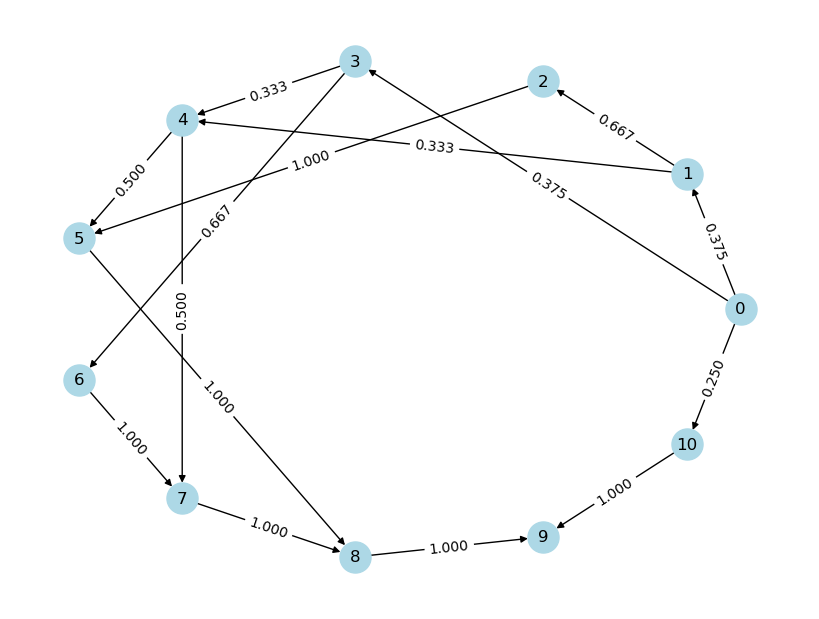

In [6]:
pos = nx.circular_layout(G)  # Layout for the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True)

# Add edge labels with weights
edge_labels = {(u, v): f'{d["cond_prob"]:.3f}' for (u, v, d) in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
